In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
%matplotlib inline


/Users/Trent/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h3> Data Cleaning </h3>

In [3]:
#reading data in
df = pd.read_csv('data/Train.csv')
df.columns = np.array([(str(x)).lower() for x in df.columns])

#Selecting only relevant columns
df = df[['modelid', 'auctioneerid', 'yearmade', 'machinehourscurrentmeter', \
        'saledate', 'saleprice', 'state', 'productgroup']]

#converting date to month and year
df['sale_month'] = pd.to_datetime(df['saledate'], infer_datetime_format = True).dt.month
df['sale_year'] = pd.to_datetime(df['saledate'], infer_datetime_format = True).dt.year
df.drop('saledate', axis = 1, inplace = True)

#casting saleprice as float (we will come back to this)
df.saleprice = df.saleprice.astype(float)

/Users/Trent/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<h3>Make Dummy Variables for Categorical Features</h3>
We had to select categorical features with a small number of categories.  Creating Dummy Variables for a large number of possible feature values froze our computers up.

In [4]:
df_dummies = pd.get_dummies(df[['state', 'productgroup']])
df = pd.concat([df_dummies, df], axis=1)
df.drop(['state', 'productgroup', 'machinehourscurrentmeter'], axis = 1, inplace = True)

<h3>Get Train Test Split</h3>
Before we could get the train test split we had to perform imputation on the AuctioneerID column. We set the missing values to the most frequently chosen value using SKlearn.

In [5]:
y = df.pop('saleprice')
X = df.values

In [6]:
#Impute auctioneerid, 
pute2 = Imputer(copy = False, strategy = 'most_frequent')
auctioneer = np.array(pute2.fit_transform(X[:, -5].reshape(-1,1)))
auctioneer = auctioneer.reshape(1, len(auctioneer))
X[:,-4] = auctioneer

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 64 columns):
state_Alabama           401125 non-null float64
state_Alaska            401125 non-null float64
state_Arizona           401125 non-null float64
state_Arkansas          401125 non-null float64
state_California        401125 non-null float64
state_Colorado          401125 non-null float64
state_Connecticut       401125 non-null float64
state_Delaware          401125 non-null float64
state_Florida           401125 non-null float64
state_Georgia           401125 non-null float64
state_Hawaii            401125 non-null float64
state_Idaho             401125 non-null float64
state_Illinois          401125 non-null float64
state_Indiana           401125 non-null float64
state_Iowa              401125 non-null float64
state_Kansas            401125 non-null float64
state_Kentucky          401125 non-null float64
state_Louisiana         401125 non-null float64
state_Maine             4

<h3>Creating Gradient Boosting Regressor</h3>
We converted to sales price variable to a float so that we could use regression (as opposed to Categorical Gradient Boosting). The reason for this is that we didn't want our price predicitions to be limited to the sale prices in our training data.

In [8]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
score = gb.score(X_test, y_test)
print "R squared:", score

R squared: 0.625293365754


In [9]:
mse = cross_val_score(gb, X_test, y_test, scoring='mean_squared_error', cv=5, n_jobs=-1)
print "Mean Error:", np.sqrt(-1*mse)

/Users/Trent/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Trent/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Trent/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Trent/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/T

Mean Error: [ 13936.07309393  14148.70605092  14373.94358398  14273.8607606
  14161.88390178]


<h3>Visualizing Errors</h3>

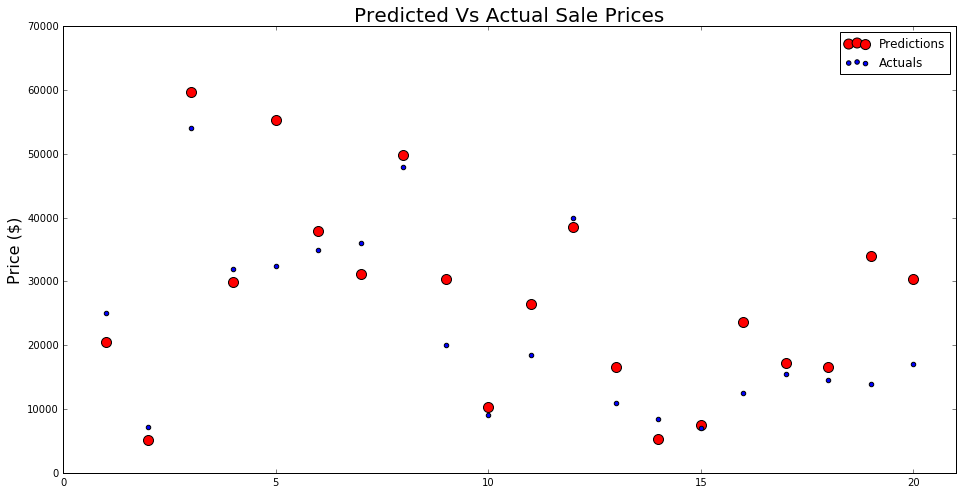

In [10]:
predictions = gb.predict(X_test[20:40])
range_vals = range(1,21)
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111)
ax.scatter(range_vals, predictions, c='r', label='Predictions', s=100)
ax.scatter(range_vals, y_test[20:40], c='b', label='Actuals', s=20)
ax.set_xlim([0,21])
ax.set_title('Predicted Vs Actual Sale Prices', fontsize=20)
ax.set_ylabel('Price ($)', fontsize = 16)
ax.legend(loc = 'best')

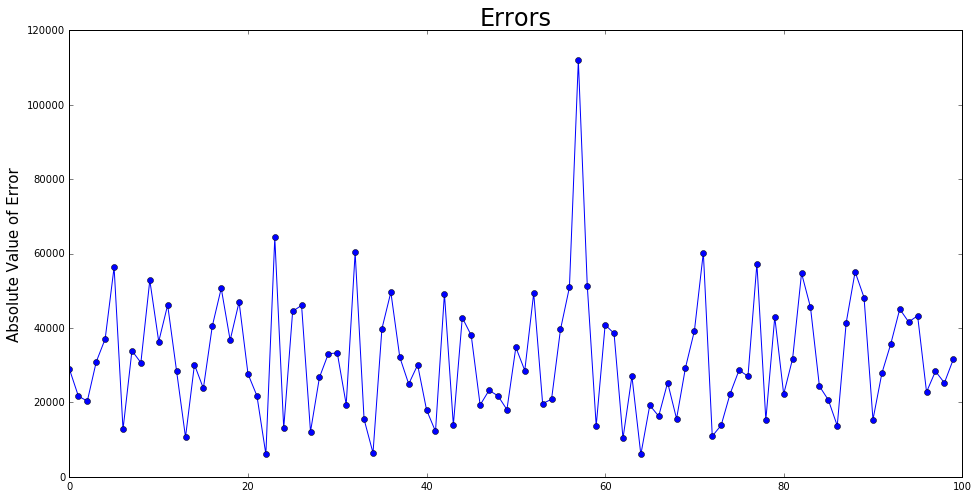

In [11]:
mask = np.random.choice(len(X_test), 100)
new_predictions = gb.predict(X_test[mask])
actuals = [y[i] for i in mask]
errors = actuals = new_predictions
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111)
ax.plot(range(100), errors, marker='o')
ax.set_title('Errors', fontsize = 24)
ax.set_ylabel('Absolute Value of Error', fontsize=15)